# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, we will create a neural network that classifies real-world images of digits.

We'll start by running some imports, and loading the dataset. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For this project, we will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Our goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
# Extract the training and testing images and labels 

x_train = train['X']
x_train = np.array(x_train)
x_train = np.moveaxis(x_train, -1, 0)
print('x_train shape = ', x_train.shape) 

y_train = train['y']
y_train = np.array(y_train)
y_train = to_categorical(y_train - 1, num_classes=10)
#one-hot encoding because labels are from 1-10
print('y_train shape = ', y_train.shape) 

x_test = test['X']
x_test = np.array(x_test)
x_test = np.moveaxis(x_test, -1, 0)
print('x_test shape = ', x_test.shape) 

y_test = test['y']
y_test = np.array(y_test)
y_test = to_categorical(y_test - 1, num_classes=10) 
#one-hot encoding because labels are from 1-10
print('y_test shape = ', y_test.shape) 

x_train shape =  (73257, 32, 32, 3)
y_train shape =  (73257, 10)
x_test shape =  (26032, 32, 32, 3)
y_test shape =  (26032, 10)


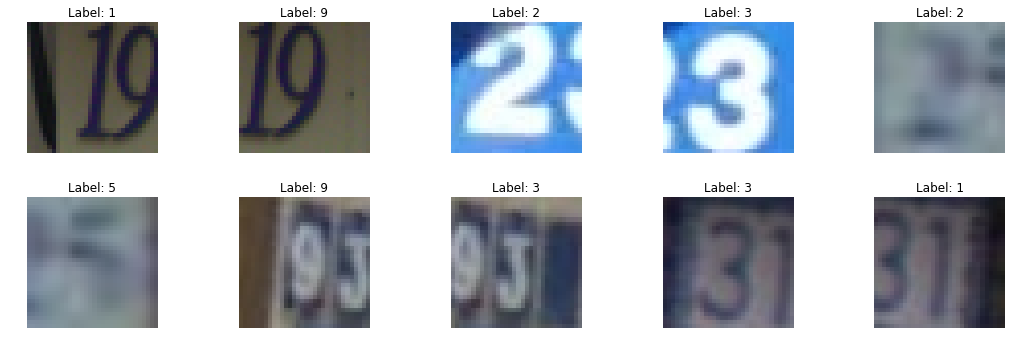

In [5]:
# Select a random sample of images and corresponding labels 
# from the dataset (at least 10), and display them in a figure.

plt.figure(figsize=(15, 5))  # Set the figure size
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows and 5 columns for 10 images and labels
    plt.imshow(x_train[i,:,:,:])  # Display the image
    label = np.argmax(y_train[i])  # Find the index with the max value (which corresponds to the class)
    plt.title(f"Label: {label + 1}")
    plt.axis('off')  # Remove the axis for clarity

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [6]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.

# Convert to grayscale by averaging across the color channels
x_train_gray = np.mean(x_train, axis=-1, keepdims=True)  # Shape becomes (73257, 32, 32, 1)
x_test_gray = np.mean(x_test, axis=-1, keepdims=True)  # Shape becomes (73257, 32, 32, 1)

print("x_train_gray shape:", x_train_gray.shape)
print("x_test_gray shape:", x_test_gray.shape)

x_train_gray shape: (73257, 32, 32, 1)
x_test_gray shape: (26032, 32, 32, 1)


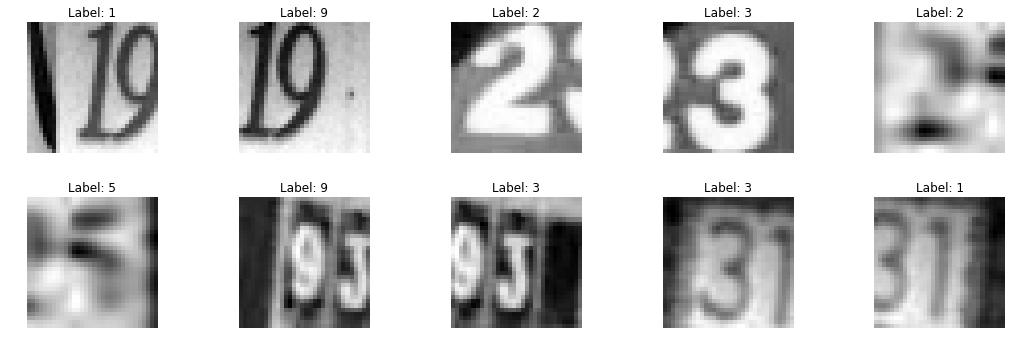

In [7]:
# Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), 
# and display them in a figure.

plt.figure(figsize=(15, 5))  # Set the figure size
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows and 5 columns for 10 images and labels
    plt.imshow(x_train_gray[i,:,:,0], cmap='gray')  # Display the image
    label = np.argmax(y_train[i])  # Find the index with the max value (which corresponds to the class)
    plt.title(f"Label: {label + 1}")
    plt.axis('off')  # Remove the axis for clarity

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [8]:
# END OF SECTION

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
# Defining a function to create a MLP classifier model

def get_model():
    model = Sequential([
        Flatten(input_shape = (32,32,1), name = 'flatten'),
        Dense(256, activation = 'relu', name = 'dense1'),
        Dense(128, activation = 'relu', name = 'dense2'),
        Dense(64, activation = 'relu', name = 'dense3'),
        Dense(10, activation = 'softmax', name = 'softmax')
    ])
    
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [11]:
# Defining some useful callbacks

def get_checkpoint_best_only():
    
    checkpoint_path = 'checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                 save_weights_only = True,
                                 save_best_only = True,
                                 monitor = 'val_accuracy',
                                 frequency = 'epoch',
                                 verbose = 1)
    
    return checkpoint

def get_early_stopping():
    
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, mode="max")
    
    return earlystopping

In [12]:
# Creating a model instance

mlp_model = get_model()
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               262400    
_________________________________________________________________
dense2 (Dense)               (None, 128)               32896     
_________________________________________________________________
dense3 (Dense)               (None, 64)                8256      
_________________________________________________________________
softmax (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Creating callbacks to be used

checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [14]:
# Fitting the data

history = mlp_model.fit(x_train_gray, y_train, 
              batch_size=64, validation_split=0.10, 
              epochs = 30, verbose = 1,
              callbacks = [checkpoint_best_only, early_stopping])

# Used to test model changes quickly
'''
mlp_model.fit(x_train_gray[:10000], y_train[:10000], 
              batch_size=64, validation_split=0.15, 
              epochs = 15, verbose = 1,
              callbacks = [checkpoint_best_only, early_stopping])
'''

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65728/65931 [============================>.] - ETA: 0s - loss: 6.8696 - accuracy: 0.1663
Epoch 00001: val_accuracy improved from -inf to 0.23942, saving model to checkpoints_best_only/checkpoint
65931/65931 [==============================] - 31s 467us/sample - loss: 6.8558 - accuracy: 0.1665 - val_loss: 2.3052 - val_accuracy: 0.2394
Epoch 2/30
65856/65931 [============================>.] - ETA: 0s - loss: 1.9265 - accuracy: 0.3701
Epoch 00002: val_accuracy improved from 0.23942 to 0.48362, saving model to checkpoints_best_only/checkpoint
65931/65931 [==============================] - 28s 426us/sample - loss: 1.9263 - accuracy: 0.3701 - val_loss: 1.6299 - val_accuracy: 0.4836
Epoch 3/30
65792/65931 [============================>.] - ETA: 0s - loss: 1.5002 - accuracy: 0.5228
Epoch 00003: val_accuracy improved from 0.48362 to 0.53481, saving model to checkpoints_best_only/checkpoint
65931/65931 [==============================] - 

'\nmlp_model.fit(x_train_gray[:10000], y_train[:10000], \n              batch_size=64, validation_split=0.15, \n              epochs = 15, verbose = 1,\n              callbacks = [checkpoint_best_only, early_stopping])\n'

In [15]:
# Plotting graphs to see loss vs epoch and accuracy vs epoch

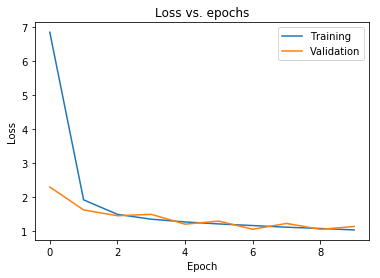

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

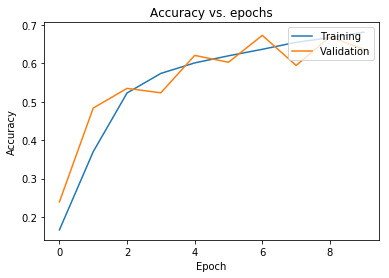

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [18]:
# Testing on the test set

test_loss, test_acc = mlp_model.evaluate(x_test_gray, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc))
print('Test loss: {loss:0.3f}'.format(loss=test_loss))

Test accuracy: 0.623
Test loss: 1.263


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
# Defining a function to create a cnn model

def get_model_cnn():
    model = Sequential([
        Conv2D(filters = 8, input_shape = (32, 32, 1), kernel_size = (3, 3), activation = 'relu', 
               padding = 'same', name = 'conv_1'),
        BatchNormalization(name = 'batch_normalization_1'),
        MaxPooling2D(pool_size = (2, 2), name = 'pool_1'),
        Dropout(0.25, name='dropout_1'),
        Conv2D(filters = 4, kernel_size = (3, 3), activation = 'relu', 
               padding = 'same', name = 'conv_2'),
        BatchNormalization(name = 'batch_normalization_2'),
        MaxPooling2D(pool_size = (2, 2), name = 'pool_2'),
        Dropout(0.25, name='dropout_2'),
        Flatten(name = 'flatten'),
        Dense(units = 32, activation = 'relu', name = 'dense_1'),
        Dense(units = 10, activation = 'softmax', name = 'dense_2')
    ])
    
    model.compile(optimizer = 'adam', 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model


In [21]:
# Defining a separate checkpoint for weights for the best cnn run

def get_checkpoint_best_only_cnn():
    
    checkpoint_path = 'checkpoints_best_only_cnn/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                 save_weights_only = True,
                                 save_best_only = True,
                                 monitor = 'val_accuracy',
                                 frequency = 'epoch',
                                 verbose = 1)
    
    return checkpoint


In [22]:
# Creating a cnn model instance

cnn_model = get_model_cnn()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 4)         292       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 4)          

In [23]:
# Creating callbacks to be used

checkpoint_best_only_cnn = get_checkpoint_best_only_cnn()
early_stopping = get_early_stopping()

In [24]:
# Fitting the data and saving to history so we can plot the changes in accuracy and loss

history_cnn = cnn_model.fit(x_train_gray, y_train, 
              batch_size=64, validation_split=0.10, 
              epochs = 30, verbose = 1,
              callbacks = [checkpoint_best_only_cnn, early_stopping])

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65920/65931 [============================>.] - ETA: 0s - loss: 1.8335 - accuracy: 0.3617
Epoch 00001: val_accuracy improved from -inf to 0.64988, saving model to checkpoints_best_only_cnn/checkpoint
65931/65931 [==============================] - 207s 3ms/sample - loss: 1.8333 - accuracy: 0.3617 - val_loss: 1.0725 - val_accuracy: 0.6499
Epoch 2/30
65920/65931 [============================>.] - ETA: 0s - loss: 0.9576 - accuracy: 0.6971
Epoch 00002: val_accuracy improved from 0.64988 to 0.79156, saving model to checkpoints_best_only_cnn/checkpoint
65931/65931 [==============================] - 205s 3ms/sample - loss: 0.9575 - accuracy: 0.6971 - val_loss: 0.6758 - val_accuracy: 0.7916
Epoch 3/30
65920/65931 [============================>.] - ETA: 0s - loss: 0.8154 - accuracy: 0.7477
Epoch 00003: val_accuracy improved from 0.79156 to 0.80945, saving model to checkpoints_best_only_cnn/checkpoint
65931/65931 [========================

In [25]:
# Plotting graphs to see loss vs epoch and accuracy vs epoch

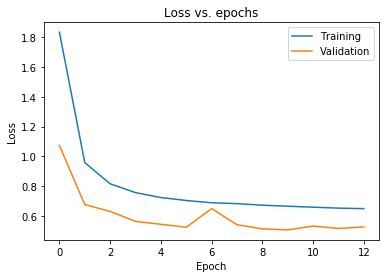

In [26]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

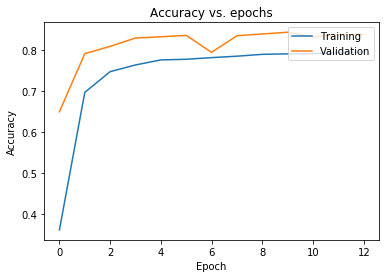

In [27]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [28]:
# Testing on the test set

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(x_test_gray, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc_cnn))
print('Test loss: {loss:0.3f}'.format(loss=test_loss_cnn))

Test accuracy: 0.821
Test loss: 0.587


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [38]:
mlp_model_best = get_model()
mlp_model_best.load_weights("checkpoints_best_only/checkpoint")
mlp_model_best.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               262400    
_________________________________________________________________
dense2 (Dense)               (None, 128)               32896     
_________________________________________________________________
dense3 (Dense)               (None, 64)                8256      
_________________________________________________________________
softmax (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [39]:
test_loss_mlp_best, test_acc_mlp_best = mlp_model_best.evaluate(x_test_gray, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc_mlp_best))
print('Test loss: {loss:0.3f}'.format(loss=test_loss_mlp_best))

Test accuracy: 0.641
Test loss: 1.251


In [40]:
cnn_model_best = get_model_cnn()
cnn_model_best.load_weights("checkpoints_best_only_cnn/checkpoint")
cnn_model_best.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 4)         292       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 4)         16        
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 4)          

In [41]:
test_loss_cnn_best, test_acc_cnn_best = cnn_model_best.evaluate(x_test_gray, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc_cnn_best))
print('Test loss: {loss:0.3f}'.format(loss=test_loss_cnn_best))

Test accuracy: 0.828
Test loss: 0.569


In [42]:
import matplotlib.pyplot as plt
import numpy as np

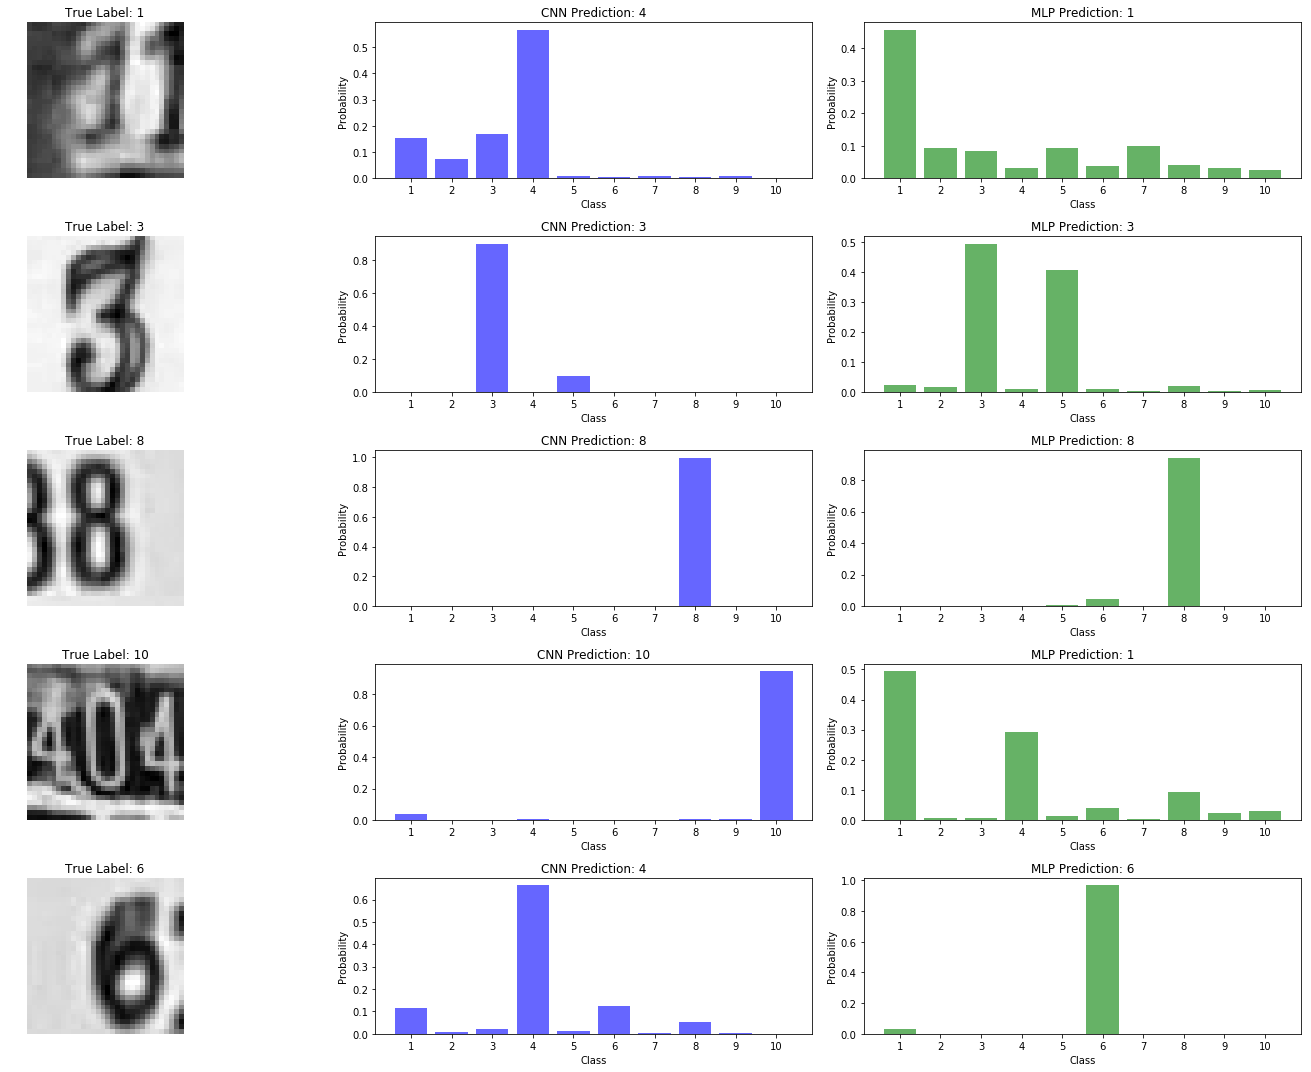

In [43]:
# Randomly select 5 images
num_images = 5
random_indices = np.random.choice(x_test_gray.shape[0], num_images, replace=False)
test_images = x_test_gray[random_indices]
true_labels = np.argmax(y_test[random_indices], axis=1)  # Convert one-hot encoded labels to integers

# Get predictions
cnn_predictions = cnn_model_best.predict(test_images)  # CNN predictive distributions
mlp_predictions = mlp_model_best.predict(test_images)  # MLP predictive distributions

# Plot the results
plt.figure(figsize=(20, 15))

for i in range(num_images):
    # image
    plt.subplot(num_images, 3, 3 * i + 1)  # 3 columns per row: Image | CNN | MLP
    plt.imshow(test_images[i].squeeze(), cmap='gray')  # Display grayscale image
    plt.title(f"True Label: {true_labels[i] + 1}", fontsize=12)  # True label
    plt.axis('off')

    # CNN predictions
    plt.subplot(num_images, 3, 3 * i + 2)
    plt.bar(range(1, 11), cnn_predictions[i], color='blue', alpha=0.6)  # Class probabilities
    cnn_pred_label = np.argmax(cnn_predictions[i]) + 1  # CNN predicted label
    plt.title(f"CNN Prediction: {cnn_pred_label}", fontsize=12)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks(range(1, 11))

    # MLP predictions
    plt.subplot(num_images, 3, 3 * i + 3)
    plt.bar(range(1, 11), mlp_predictions[i], color='green', alpha=0.6)  # Class probabilities
    mlp_pred_label = np.argmax(mlp_predictions[i]) + 1  # MLP predicted label
    plt.title(f"MLP Prediction: {mlp_pred_label}", fontsize=12)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks(range(1, 11))

plt.tight_layout()
plt.show()